<a href="https://colab.research.google.com/github/osiris/test/blob/develop/ia-nlp-03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico 3: Redes Neuronales para PLN

# 0 - Setup

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvfz aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [ ]:
def load_imdb_data(path):
    texts, labels = [], []

    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(path, label_type)
        for fname in os.listdir(dir_name):
            with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(0 if label_type == 'neg' else 1)

    return texts, labels

train_texts, train_labels = load_imdb_data('/content/aclImdb/train')
test_texts, test_labels = load_imdb_data('/content/aclImdb/test')

In [ ]:
print('Input text: ',train_texts[0])
print('Label: ',train_labels[0])

Input text:  This movie started out good, i felt like i was watching an adult version of Seinfeld. Much to quickly i started questioning the situations and actions of the main characters, and found no answers to why they were doing what they were doing. All the acting was superb but only a few scenes had brief moments where they were actually funny. Dan Cortese was amazing. I loved him in this role. His agent should show this movie to casting agents. Watch the first few scenes and then find something better, or else you will find yourself totally lost in this mess. I found this in a bin at a video store. It cost me two dollars and due to the rareness of this movie i feel like it was a good price.
Label:  0


# 1 - Preprocesamiento de datos

Primero preprocesamos los datos con CountVectorizer.

Creamos [datasets y dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) de PyTorch para manejar los datos. El Dataset provee métodos de cómo obtener uno o más datapoints y el tamaño del dataset. El Dataloader nos dará utilidades para dividir el dataset en batches.

In [ ]:
# Usamos BoW y convertimos a vectores de 5000 dimensiones
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

y_train = train_labels
y_test = test_labels

# Convertimos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Creamos dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2 - Una primera red neuronal

Una capa o red que querramos implementar debe heredar de la clase [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module).

Debemos definir método \_\_init__ y método forward que pasará los datos de entrada a través de la red.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=5000):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# 3 - Entrenamos el Modelo

Instanciamos el modelo, la función de costo y el optimizador.

In [ ]:
model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Definimos cantidad de épocas a entrenar.

In [ ]:
num_epochs = 10

Ejecutamos el loop de entrenamiento (puede demorar unos minutos).

In [ ]:
for epoch in range(num_epochs):
    model.train()  # Ponemos el modo entrenamiento
    total_loss = 0.0  # La funcion de pérdida al principio de la época es 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reseteamos los gradientes a 0
        outputs = model(data).squeeze()  # Obtenemos las salidas del modelo y removemos las dimensiones redundantes
        loss = criterion(outputs, target)  # Comparamos con las anotaciones
        loss.backward()  # Calculamos los gradientes
        optimizer.step()  # Actualizamos los pesos de la red
        total_loss += loss.item()  # Guardamos la loss para visualizar
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")


Epoch 1/10, Loss: 0.3437945833786979
Epoch 2/10, Loss: 0.20762638001443098
Epoch 3/10, Loss: 0.10456124759133896
Epoch 4/10, Loss: 0.031539191996901715
Epoch 5/10, Loss: 0.010144232742479749
Epoch 6/10, Loss: 0.006235586995350258
Epoch 7/10, Loss: 0.0066499598763868585
Epoch 8/10, Loss: 0.005706349378424365
Epoch 9/10, Loss: 0.007645209803671526
Epoch 10/10, Loss: 0.007291405772871711


# 4 - Evaluación del modelo

In [ ]:
model.eval()  # Ponemos en módulo eval
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 84.74%


# 5 - Usando redes recurrentes

En esta sección repetiremos el pipeline anterior, pero preparando los datos para usar una red recurrente LSTM.

Este modelo es mucho más grande y costoso de computar, por lo que la mejor opción es pasar el cómputo a GPU. Para hacerlo tenemos que hacer unas modificaciones para especificarle a PyTorch dónde queremos entrenar el modelo.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Si el output de la celda anterior dice "cpu" entonces necesitamos cambiar el runtime de nuestro entorno. Para eso seleccionamos "Runtime" y cambiamos el entorno para usar una T4:
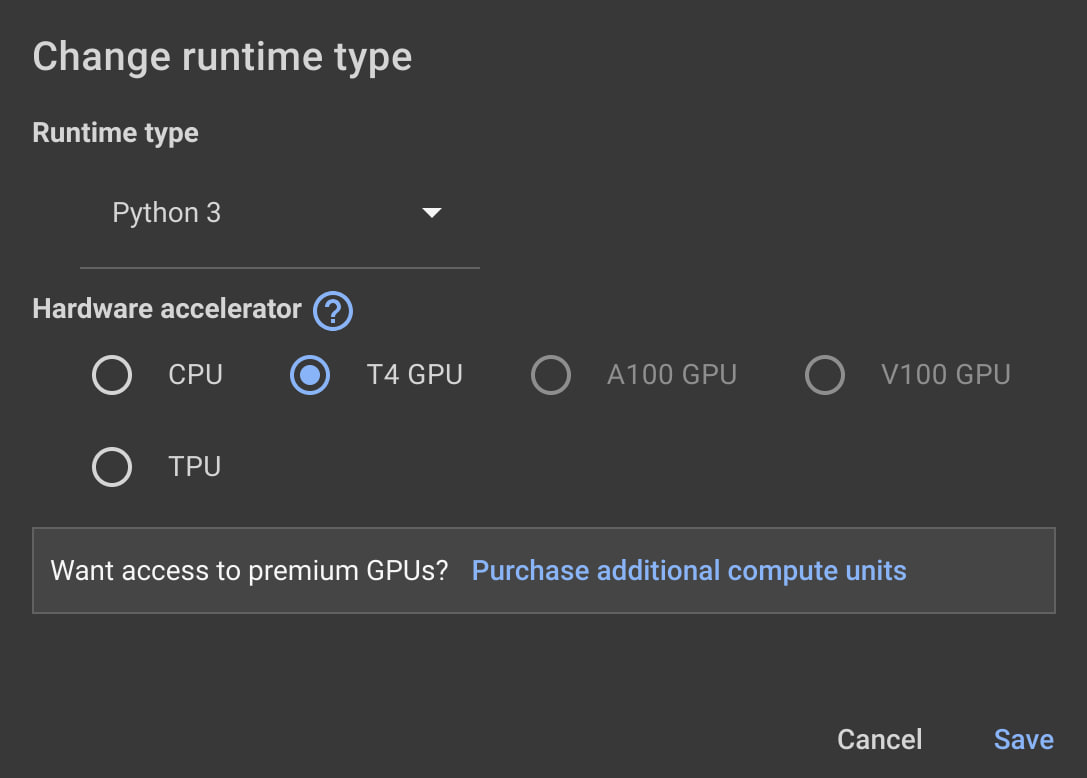

Creamos el dataset para los datos. Agregamos el preprocesamiento en el mismo lugar.

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

        # Tokenizado y creación de vocabulario
        self.tokenized_texts = self.tokenize(self.texts)
        self.vocabulary, self.word2idx, self.idx2word = self.build_vocab(self.tokenized_texts)

        # Convertir a tokens y padding
        self.int_sequences = self.tokens_to_integers(self.tokenized_texts, self.word2idx)
        self.padded_sequences = self.pad_sequences(self.int_sequences)

        # Convertir a tensores
        self.sequences_tensor = torch.tensor(self.padded_sequences, dtype=torch.long)
        self.labels_tensor = torch.tensor(self.labels, dtype=torch.float32)

    def tokenize(self, texts):
        return [word_tokenize(text) for text in texts]

    def build_vocab(self, tokenized_texts):
        vocabulary = Counter(word for tokens in tokenized_texts for word in tokens)
        word2idx = {word: idx + 2 for idx, (word, _) in enumerate(vocabulary.most_common())}
        word2idx["<PAD>"] = 0  # Padding
        word2idx["<UNK>"] = 1  # Unknown
        idx2word = {idx: word for word, idx in word2idx.items()}
        return vocabulary, word2idx, idx2word

    def tokens_to_integers(self, tokenized_texts, word2idx):
        return [[word2idx.get(word, word2idx["<UNK>"]) for word in tokens] for tokens in tokenized_texts]

    def pad_sequences(self, sequences):
        max_length = max(len(seq) for seq in sequences)
        return [seq + [self.word2idx["<PAD>"]] * (max_length - len(seq)) for seq in sequences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences_tensor[idx], self.labels_tensor[idx]


Instanciamos los datasets (esto puede demorar un momento).

In [ ]:
train_dataset = IMDbDataset(train_texts, train_labels)
test_dataset = IMDbDataset(test_texts, test_labels)

Instanciamos los dataloaders para los datos.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Definimos la red. La red tendrá las siguientes capas:


*   Capa de embeddings: convierte el token numérico en un vector
*   Capa LSTM
*   Capa FC: *fully-connected*. Una capa para convertir la salida de la LSTM en un valor para predecir.



In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_output = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(final_output)

Seleccionamos los hiperparámetros del modelo. Estos son:


*   vocab_size: tamañó del vocabulario. Necesario para la capa de embeddings.
*   embedding_dim: tamaño del embedding generado
*   hidden_dim: tamaño del vector de salida de la LSTM
*   output_dim: tamaño de la salida de la red



In [ ]:
vocab_size = len(train_dataset.vocabulary) + 2  # Contando <PAD> and <UNK>
embedding_dim = 100
hidden_dim = 256
output_dim = 1

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model = model.to(device)  # Movemos el modelo a GPU
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Preparamos el entrenamiento (esto puede demorar un momento).

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Ponemos el modo entrenamiento
    total_loss = 0.0  # La funcion de pérdida al principio de la época es 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_X, batch_y in progress_bar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Enviamos los tensores a GPU
        optimizer.zero_grad()  # Reseteamos los gradientes a 0
        outputs = model(batch_X).squeeze()  # Obtenemos las salidas del modelo y removemos las dimensiones redundantes
        loss = criterion(outputs, batch_y)  # Comparamos con las anotaciones
        loss.backward()  # Calculamos los gradientes
        optimizer.step()  # Actualizamos los pesos de la red
        total_loss += loss.item()  # Guardamos la loss para visualizar

Epoch 4/10:  11%|█         | 85/782 [00:06<00:49, 14.05it/s]


KeyboardInterrupt: ignored

Evaluamos el modelo.

In [ ]:
model.eval()
total_test_loss = 0.0
correct_predictions = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Enviamos los tensores a GPU
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        total_test_loss += loss.item()
        correct_predictions += ((outputs > 0.5).float() == batch_y).sum().item()

print(f"Test Loss: {total_test_loss/len(test_loader)}")
print(f"Test Accuracy: {100 * correct_predictions / len(test_labels):.2f}%")

Test Loss: 0.6931504320610514
Test Accuracy: 50.00%
